In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Data Sample
![A sample of data](https://gitee.com/jiangdawang/pic/raw/master/20211212202647.png)

#### 数据预处理

##### #读取数据

In [ ]:

data = pd.read_csv('industry_data.csv')
#data.info()

##### 替换中文符号

In [3]:
columns = data.columns.to_list()
columns = [re.sub('_\d、','',x) for x in columns]
columns = [re.sub('_（\d）','',x) for x in columns]
columns
data.columns = columns

In [4]:
def create_nan_2015(x):
    tmp = {}
    for i in data.columns:
        if i == 'Year':
            tmp[i] = 2015
        elif i == 'Month':
            tmp[i] = f'1-{x}'
        elif i == 'date_time':
            tmp[i] = f'2011年1-{x}月'
        else:
            tmp[i] = np.nan
    return tmp

In [5]:
def create_nan_2011(x):
    tmp = {}
    for i in data.columns:
        if i == 'Year':
            tmp[i] = 2011
        elif i == 'Month':
            tmp[i] = f'1-{x}'
        elif i == 'date_time':
            tmp[i] = f'2011年1-{x}月'
        else:
            tmp[i] = np.nan
    return tmp

##### 正则读取月份年份

In [6]:
print(data.shape)
data.drop('from_url',axis = 1,inplace=True)
data = data.drop_duplicates()
print(data.shape)
data['date_time'] = data['info'].apply(lambda x: re.findall(r'.*(?=保险.*)',x)[0])
data['date_time'] = data['date_time'].replace({'2011年': '2011年1-12月',
                            '2012年': '2012年1-12月',
                            '2013年': '2013年1-12月',
                            '2014年': '2014年1-12月',
                            '2015年': '2015年1-12月',
                            '2016年': '2016年1-12月',
                            '2017年': '2017年1-12月',
                            '2011年2月':'2011年1-2月',
                            '2011年3月':'2011年1-3月',
                            '2011年6月':'2011年1-6月',
                            '2011年7月':'2011年1-7月'})

data['Year'] = data.date_time.apply(lambda x: int(re.findall(r'\d{4}(?=年)',x)[0]))
data['Month'] = data.date_time.apply(lambda x: re.findall(r'(?<=年).*(?=月)',x)[0])
data.drop('info',inplace= True,axis = 1)
month_cat = ['1'] + [f'1-{i}' for i in range(2,13)]
#data = data.append(create_nan_2011(4),ignore_index=True)
#data = data.append(create_nan_2011(5),ignore_index=True)
#data = data.append(create_nan_2015(2),ignore_index=True)
#data = data.append(create_nan_2015(3),ignore_index=True)
data['Month'] = pd.Categorical(data['Month'],ordered = True,categories=month_cat)           
data = data.sort_values(by=['Year','Month'])

(107, 23)
(106, 22)


##### 读取所有的浮点型数据并interpolate缺失值

In [7]:
numerical_col = data.select_dtypes(float).columns.tolist()
data[numerical_col] = data[numerical_col].interpolate(method='linear') 

In [9]:

def cal_each_month(group):
    #year = re.findall(r'\d{4}(?=年)',group.loc[0,'date_time'])[0]
    #print(year)
    vals = group.loc[:,numerical_col]
    vals_lag = vals.shift(1).fillna(0)
    rV = vals - vals_lag

    #index = range(1,13)
    #index = [f'{year}/{i}' for i in range(1,13)]
    #rV['dd'] = index
    #columns = numerical_col
    return vals - vals_lag
dd = data.groupby('Year').apply(cal_each_month)

In [10]:
al = []
for x in data.Year.unique():
    
    if x == 2018:
        ls = ['2018-1','2018-2']
    else:
        ls = [f'{x}-{i}' for i in range(1,13)]
    al.extend(ls)
len(al)
al = pd.Series(al)

In [11]:
dd.insert(0,'date',al)
dd['date'] = pd.to_datetime(dd['date'])

In [13]:
dd = dd.sort_values('date',ascending=True)

In [ ]:
D = data[data['Year']==2017]
vals = D.loc[:,numerical_col]
vals_lag = vals.shift(1).fillna(0)
vals - vals_lag

In [185]:
len(data)

106

##### 寻找缺失的月份

In [293]:
data.groupby('Year')['资产总额'].count()

Year
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018     2
Name: 资产总额, dtype: int64

##### 找到年份数据

In [16]:
Date_Year = (data['date_time'].str.contains('12月')) 
data[Date_Year]


,原保险保费收入,原保险保费收入_财产险,原保险保费收入_人身险,原保险保费收入_人身险_寿险,原保险保费收入_人身险_健康险,原保险保费收入_人身险_人身意外伤害险,人身保险公司保户投资款新增交费,人身保险公司投连险独立账户新增交费,原保险赔付支出,原保险赔付支出_财产险,原保险赔付支出_人身险,原保险赔付支出_人身险_寿险,原保险赔付支出_人身险_健康险,原保险赔付支出_人身险_人身意外伤害险,业务及管理费,银行存款,投资,资产总额,养老保险公司企业年金缴费,养老保险公司企业年金受托管理资产,养老保险公司企业年金投资管理资产,date_time,Year,Month
94,1.113730e+08,28758335.00,8.261465e+07,7.457438e+07,5739775.40,2300494.00,NaN,NaN,3.125483e+07,15757845.00,15496982.00,12687425.00,2170336.60,639220.32,12340587.00,1.051968e+08,2.689743e+08,4.063475e+08,1666158.7,6380825,4804699.3,2009年1-12月,2009,1-12
82,1.452797e+08,38956424.71,1.063233e+08,9.679509e+07,6774658.47,2753537.94,NaN,NaN,3.200429e+07,17560273.50,14444018.14,11089892.04,2640219.87,713906.23,15383514.70,1.390997e+08,3.213665e+08,5.048161e+08,3574376.60,10391435.90,7089593.60,2010年1-12月,2010,1-12
72,1.433925e+08,46178231.58,9.721428e+07,8.695591e+07,6917212.77,3341154.20,NaN,NaN,3.929373e+07,21869338.06,17424394.32,13009348.85,3596650.21,818395.26,18823799.47,1.773717e+08,3.773667e+08,6.013810e+08,4104683.73,13781773.16,13246962.68,2011年1-12月,2011,1-12
60,1.548793e+08,53309273.47,1.015700e+08,8.908057e+07,8627607.13,3861847.73,NaN,NaN,4.716318e+07,28163316.38,18999868.23,15050143.88,2981707.45,968016.90,21714623.69,2.344600e+08,4.509658e+08,7.354573e+08,6617266.36,20090059.76,17111617.63,2012年1-12月,2012,1-12
48,1.722224e+08,62122577.83,1.100998e+08,9.425141e+07,11234960.47,4613422.77,3.212318e+07,831751.31,6.212903e+07,34391379.13,27737651.16,22531329.39,4111271.11,1095050.66,24595864.37,2.264098e+08,5.423243e+08,8.288695e+08,5887621.45,24953391.99,21675214.21,2013年1-12月,2013,1-12
36,2.023481e+08,72033761.12,1.303143e+08,1.090169e+08,15871785.71,5425659.20,3.916754e+07,2894978.55,7.216212e+07,37882124.70,34279999.89,27284267.23,5711551.87,1284180.79,27957924.00,2.523344e+08,6.699741e+08,1.015915e+09,6067598.89,31599422.28,28578899.31,2014年1-12月,2014,1-12
26,2.428252e+08,79949687.36,1.628755e+08,1.324152e+08,24104715.15,6355584.95,7.646564e+07,6778832.75,8.674140e+07,41941665.57,44799731.92,35651680.05,7629656.85,1518395.01,33367214.98,2.434967e+08,8.744581e+08,1.235978e+09,8742036.99,41687972.86,35255111.75,2015年1-12月,2015,1-12
14,3.095910e+08,87244981.36,2.223460e+08,1.744222e+08,40424967.91,7498892.86,1.186016e+08,9389744.45,1.051289e+08,47261838.89,57867060.95,46029461.77,10007522.22,1830076.96,38955248.72,2.484421e+08,1.090665e+09,1.511692e+09,NaN,NaN,NaN,2016年1-12月,2016,1-12
2,3.658101e+08,98346579.05,2.674635e+08,2.145557e+08,43894603.83,9013240.68,5.892364e+07,4704175.97,1.118079e+08,50874495.97,60933436.60,45748906.94,12947670.22,2236859.45,42880643.40,1.927407e+08,1.299321e+09,1.674894e+09,NaN,NaN,NaN,2017年1-12月,2017,1-12


In [22]:
data[Date_Year].date_time.tolist()

['2009年1-12月',
 '2010年1-12月',
 '2011年1-12月',
 '2012年1-12月',
 '2013年1-12月',
 '2014年1-12月',
 '2015年1-12月',
 '2016年1-12月',
 '2017年1-12月']

### 年份数据图表

#### 保险保费及支出变动 Line Chart

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                        y=data[Date_Year].原保险保费收入.tolist(),
                        mode='lines',
                        name='原保险保费收入'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出.tolist(),
                mode='lines',
                name = '原保险赔付支出'))

fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_财产险.tolist(),
                mode='lines',
                name = '原保险保费收入_财产险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_人身险.tolist(),
                mode='lines',
                name = '原保险保费收入_人身险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出_财产险.tolist(),
                mode='lines',
                name = '原保险赔付支出_财产险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出_人身险.tolist(),
                mode='lines',
                name = '原保险赔付支出_人身险'))

                
fig.update_layout(title = '保险保费及支出变动', xaxis_title='Year',yaxis_title='费用/支出')
fig.show()

#### 保险保费及支出变动细分 Line Chart

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_人身险.tolist(),
                mode='lines',
                name = '原保险保费收入_人身险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出_人身险.tolist(),
                mode='lines',
                name = '原保险赔付支出_人身险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_人身险_寿险.tolist(),
                mode='lines',
                name = '原保险保费收入_人身险_寿险'))

fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出_人身险_寿险.tolist(),
                mode='lines',
                name = '原保险赔付支出_人身险_寿险'))

fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_人身险_健康险.tolist(),
                mode='lines',
                name = '原保险保费收入_人身险_健康险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险赔付支出_人身险_健康险.tolist(),
                mode='lines',
                name = '原保险赔付支出_人身险_健康险'))
fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),
                y=data[Date_Year].原保险保费收入_人身险_人身意外伤害险.tolist(),
                mode='lines',
                name = '原保险保费收入_人身险_人身意外伤害险'))

fig.add_trace(go.Scatter(x=data[Date_Year].date_time.tolist(),

                y=data[Date_Year].原保险赔付支出_人身险_人身意外伤害险.tolist(),
                mode='lines',
                name = '原保险赔付支出_人身险_人身意外伤害险'))

fig.update_layout(title = '保险保费及支出变动细分', xaxis_title='Year',yaxis_title='费用/支出')
fig.show()


#### 原保险保费收入_财产险占比 Vs 原保险保费收入_人身险占比 Bar Chart

In [33]:
data_Year = data[Date_Year].copy()

In [35]:
data_Year['原保险保费收入_财产险占比'] = data_Year['原保险保费收入_财产险']/ data_Year['原保险保费收入']
data_Year['原保险保费收入_人身险占比'] = data_Year['原保险保费收入_人身险']/ data_Year['原保险保费收入']
data_Year['原保险赔付支出_财产险占比'] = data_Year['原保险赔付支出_财产险']/ data_Year['原保险赔付支出']
data_Year['原保险赔付支出_人身险占比'] = data_Year['原保险赔付支出_人身险']/ data_Year['原保险赔付支出']

In [38]:
dict(zip(range(0,8),range(2009,2018)))

{0: 2009, 1: 2010, 2: 2011, 3: 2012, 4: 2013, 5: 2014, 6: 2015, 7: 2016}

Text(0.5, 1.0, 'Recent Year Property Insurance Vs Individual Insurance')

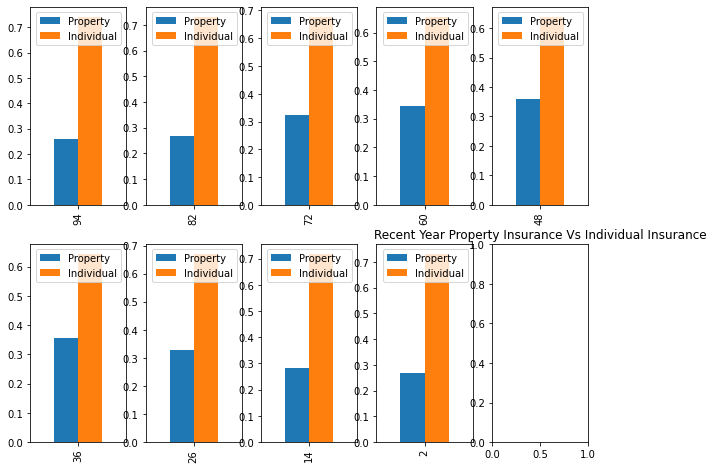

In [58]:
Year_dict = dict(zip(range(0,9),range(2009,2018)))
fig, axes = plt.subplots(2,5,figsize = (10,8))
for i in range(0,9):
    if i < 5:
        data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险保费收入_财产险占比','原保险保费收入_人身险占比']].plot(kind='bar',ax = axes[0,i]);
        axes[0,i].legend(['Property','Individual'])
    else:
        data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险保费收入_财产险占比','原保险保费收入_人身险占比']].plot(kind='bar',ax=axes[1,i-5]);
        axes[1,i-5].legend(['Property','Individual'])
plt.title('Recent Year Property Insurance Vs Individual Insurance')

In [89]:

from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2, cols=5,
    column_widths=[0.5]*5,
    row_heights=[0.5]*2,
    specs=[[{"type": "bar"}, {"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}],
           [{"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}, None]])
tra_ls = []
for i in range(5):
    x = ['财产险占比','人身险占比']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险保费收入_财产险占比','原保险保费收入_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name= Year_dict[i]),
    row=1, col =i+1
)

for i in range(5,9):
    x = ['财产险占比','人身险占比']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险保费收入_财产险占比','原保险保费收入_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name=Year_dict[i]
        ),
    row=2, col = i-4
    )
fig.update_layout(title = '原保险保费收入_财产险占比 Vs 原保险保费收入_人身险占比')
fig.show()


In [90]:
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2, cols=5,
    column_widths=[0.5]*5,
    row_heights=[0.5]*2,
    specs=[[{"type": "bar"}, {"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}],
           [{"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}, None]])
tra_ls = []
for i in range(5):
    x = ['财产险占比','人身险占比']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险赔付支出_财产险占比','原保险赔付支出_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name= Year_dict[i]),
    row=1, col =i+1
)

for i in range(5,9):
    x = ['财产险占比','人身险占比']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['原保险赔付支出_财产险占比','原保险赔付支出_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name=Year_dict[i]
        ),
    row=2, col = i-4
    )
fig.update_layout(title = '原保险赔付支出_财产险占比 Vs 原保险赔付支出_人身险占比')
fig.show()


#### 原保险保费收入-人身险细分 Bar Chart

In [106]:
data_Year['收入_寿险占比'] = data_Year['原保险保费收入_人身险_寿险']/ data_Year['原保险保费收入_人身险']
data_Year['收入_健康险占比'] = data_Year['原保险保费收入_人身险_健康险']/ data_Year['原保险保费收入_人身险']
data_Year['收入_人身意外伤害险占比'] = data_Year['原保险保费收入_人身险_人身意外伤害险']/ data_Year['原保险保费收入_人身险']
data_Year['赔付_寿险占比'] = data_Year['原保险赔付支出_人身险_寿险']/ data_Year['原保险赔付支出_人身险']
data_Year['赔付_健康险占比'] = data_Year['原保险赔付支出_人身险_健康险']/ data_Year['原保险赔付支出_人身险']
data_Year['赔付_人身险占比'] = data_Year['原保险赔付支出_人身险_人身意外伤害险']/ data_Year['原保险赔付支出_人身险']

In [97]:
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2, cols=5,
    column_widths=[0.5]*5,
    row_heights=[0.5]*2,
    specs=[[{"type": "bar"}, {"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}],
           [{"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}, None]])
tra_ls = []
for i in range(5):
    x = ['寿险','人身险','人身意外伤害险']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['收入_寿险占比','收入_健康险占比', '收入_人身意外伤害险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name= Year_dict[i]),
    row=1, col =i+1
)

for i in range(5,9):
    x = ['寿险','人身险','人身意外伤害险']
    y = data_Year[data_Year['Year']==Year_dict[i]].loc[:,['收入_寿险占比','收入_健康险占比', '收入_人身意外伤害险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,name=Year_dict[i]
        ),
    row=2, col = i-4
    )
fig.update_layout(title = '原保险保费收入-人身险')
fig.show()


#### 原保险赔付支出-人身险细分 Bar Chart

In [ ]:
dic = {i:3 for i in ['收入_寿险占比','收入_健康险占比', '收入_人身意外伤害险占比', '赔付_寿险占比', '赔付_健康险占比', '赔付_人身险占比']}
d2 = data_Year.round(dic)


In [108]:
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2, cols=5,
    column_widths=[0.5]*5,
    row_heights=[0.5]*2,
    specs=[[{"type": "bar"}, {"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}],
           [{"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}, None]])

for i in range(5):
    x = ['寿险','人身险','人身意外伤害险']
    y = d2[d2['Year']==Year_dict[i]].loc[:,['赔付_寿险占比', '赔付_健康险占比', '赔付_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,text=y,name= Year_dict[i]),
    row=1, col =i+1
)

for i in range(5,9):
    x = ['寿险','人身险','人身意外伤害险']
    y = d2[d2['Year']==Year_dict[i]].loc[:,['赔付_寿险占比', '赔付_健康险占比', '赔付_人身险占比']].squeeze(axis = 0).tolist()
    fig.add_trace(
    go.Bar(x=x,y=y, showlegend=True,text=y,name=Year_dict[i]
        ),
    row=2, col = i-4
    )
fig.update_layout(title = '原保险赔付支出-人身险')
fig.show()


In [110]:
dd.to_excel("month_data.xlsx")

<AxesSubplot:>

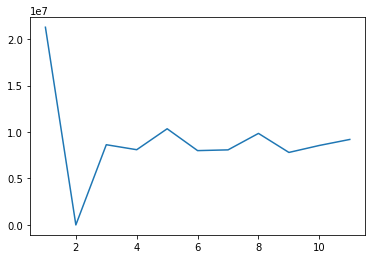

In [118]:
(data[data['Year']== 2009]['原保险保费收入'].reset_index(drop=True) - data[data['Year']== 2009]['原保险保费收入'].reset_index(drop=True).shift(1)).plot()

### 每月数据（对数据完整的年份）

#### 每月数据对比-->探究季节性

In [ ]:
fig,ax = plt.subplots(1,1)
for i in range(2009,2018):
    if i not in [2011,2015,2018]:
        (data[data['Year']== i]['原保险保费收入'].reset_index(drop=True) - data[data['Year']== i]['原保险保费收入'].reset_index(drop=True).shift(1).fillna(0)).plot(ax=ax)

In [135]:
fig = go.Figure()
for i in range(2009,2018):
    if i not in [2011,2015,2018,2012]: 
        x = list(range(1,13))
        y = (data[data['Year']== i]['原保险保费收入'].reset_index(drop=True) - data[data['Year']== i]['原保险保费收入'].reset_index(drop=True).shift(1).fillna(0)).tolist()
        fig.add_trace(go.Scatter(x=x,
                        y=y,
                        mode='lines',
                        name = f'{i} 年'))
fig.update_layout(title = '原保费收入（1-12月）', xaxis_title='月份',yaxis_title='收入')
fig.show()

In [138]:
fig = go.Figure()
for i in range(2009,2018):
    if i not in [2011,2015,2018,2012]: 
        x = list(range(1,13))
        y = (data[data['Year']== i]['原保险赔付支出'].reset_index(drop=True) - data[data['Year']== i]['原保险赔付支出'].reset_index(drop=True).shift(1).fillna(0)).tolist()
        fig.add_trace(go.Scatter(x=x,
                        y=y,
                        mode='lines',
                        name = f'{i} 年'))
fig.update_layout(title = '原赔偿支出（1-12月）', xaxis_title='月份',yaxis_title='费用')
fig.show()

In [148]:
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[0.8],
    row_heights=[1]*2,
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}]])

for i in range(2009,2018):
    if i not in [2011,2015,2018,2012]: 
        x = list(range(1,13))
        y = (data[data['Year']== i]['原保险保费收入'].reset_index(drop=True) - data[data['Year']== i]['原保险保费收入'].reset_index(drop=True).shift(1).fillna(0)).tolist()
        fig.add_trace(go.Scatter(x=x,
                        y=y,
                        mode='lines',
                        name = f'{i} 年收入'),row=1, col = 1)
        #x = list(range(1,13))
        y = (data[data['Year']== i]['原保险赔付支出'].reset_index(drop=True) - data[data['Year']== i]['原保险赔付支出'].reset_index(drop=True).shift(1).fillna(0)).tolist()
        fig.add_trace(go.Scatter(x=x,
                        y=y,
                        mode='lines',
                        name = f'{i} 年赔偿'),row=2, col = 1)
fig.update_layout(title = '原赔偿支出/收入（1-12月）')
fig.show()

<AxesSubplot:>

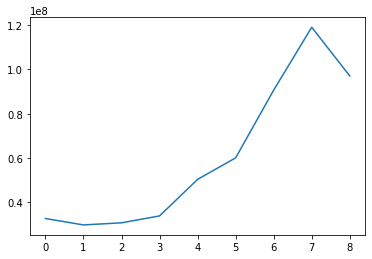

In [156]:
data[data['Month'] == '1-2']['原保险保费收入'].reset_index(drop = True).plot()

In [161]:
dd = dd.set_index(dd.date)
dd.drop('date',axis = 1, inplace = True)
dd

,原保险保费收入,原保险保费收入_财产险,原保险保费收入_人身险,原保险保费收入_人身险_寿险,原保险保费收入_人身险_健康险,原保险保费收入_人身险_人身意外伤害险,人身保险公司保户投资款新增交费,人身保险公司投连险独立账户新增交费,原保险赔付支出,原保险赔付支出_财产险,原保险赔付支出_人身险,原保险赔付支出_人身险_寿险,原保险赔付支出_人身险_健康险,原保险赔付支出_人身险_人身意外伤害险,业务及管理费,银行存款,投资,资产总额
date,,,,,,,,,,,,,,,,,,
2009-01-01,2.851518e+07,6.267249e+06,2.224793e+07,1.822958e+07,3.426597e+06,591752.220000,6.571292e+06,640352.800000,9.425589e+06,3.487974e+06,5.937615e+06,4.742045e+06,1018015.41,177554.44,2.971902e+06,2.489948e+06,-4.561332e+06,-2.005889e+06
2009-02-01,6.851919e+07,1.145466e+07,5.706453e+07,5.078745e+07,5.323376e+06,953698.580000,1.856317e+07,869157.370000,1.313109e+07,4.753829e+06,8.377258e+06,6.525965e+06,1619936.17,231357.34,3.179867e+06,1.883404e+08,1.313660e+09,1.690528e+09
2009-03-01,2.183424e+07,1.021585e+07,1.161839e+07,8.114247e+06,2.839169e+06,664974.940000,3.562622e+06,546535.650000,1.089947e+07,6.351781e+06,4.547689e+06,2.612003e+06,1693594.41,242091.57,5.822096e+06,-2.803621e+05,2.214371e+07,1.079685e+07
2009-04-01,2.008815e+07,8.519368e+06,1.156879e+07,8.285150e+06,2.634552e+06,649083.460000,4.595616e+06,185568.970000,1.006171e+07,5.078804e+06,4.982907e+06,3.360538e+06,1412272.14,210096.40,3.648516e+06,1.897346e+06,-1.203765e+06,2.112566e+06
2009-05-01,1.931451e+07,7.308528e+06,1.200598e+07,8.747082e+06,2.590383e+06,668514.120000,4.240443e+06,165568.180000,7.574095e+06,3.774005e+06,3.800089e+06,2.643290e+06,995690.08,161109.60,2.984642e+06,-1.001093e+07,1.479886e+07,3.741155e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-01,1.147641e+07,2.973274e+06,8.503139e+06,7.834668e+06,4.880456e+05,180425.310000,NaN,NaN,2.837259e+06,1.251808e+06,1.585451e+06,1.344880e+06,183986.72,56583.86,8.377280e+05,8.194801e+07,2.236362e+08,3.381544e+08
2017-11-01,1.146482e+07,4.088751e+06,7.376073e+06,6.475343e+06,6.033965e+05,297334.113333,NaN,NaN,3.261876e+06,1.691422e+06,1.570454e+06,1.107641e+06,401152.50,61660.06,1.455579e+06,4.668448e+06,1.644411e+06,1.135270e+07
2017-12-01,1.146482e+07,4.088751e+06,7.376073e+06,6.475343e+06,6.033965e+05,297334.113333,NaN,NaN,3.261876e+06,1.691422e+06,1.570454e+06,1.107641e+06,401152.50,61660.06,1.455579e+06,4.668448e+06,1.644411e+06,1.135270e+07


In [165]:
dd.index.year

Int64Index([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2018, 2018],
           dtype='int64', name='date', length=110)

In [173]:
dd[dd.index.year == 2015]

,原保险保费收入,原保险保费收入_财产险,原保险保费收入_人身险,原保险保费收入_人身险_寿险,原保险保费收入_人身险_健康险,原保险保费收入_人身险_人身意外伤害险,人身保险公司保户投资款新增交费,人身保险公司投连险独立账户新增交费,原保险赔付支出,原保险赔付支出_财产险,原保险赔付支出_人身险,原保险赔付支出_人身险_寿险,原保险赔付支出_人身险_健康险,原保险赔付支出_人身险_人身意外伤害险,业务及管理费,银行存款,投资,资产总额
date,,,,,,,,,,,,,,,,,,
2015-01-01,1.081646e+07,4.484942e+06,6.331520e+06,5.556105e+06,563118.230000,212296.350000,NaN,NaN,4154407.05,2.871071e+06,1.283336e+06,932838.81,250846.62,99650.88,2.746643e+06,1.066644e+07,5.008157e+06,1.675939e+07
2015-02-01,1.033888e+07,3.736252e+06,6.602632e+06,5.854019e+06,510093.080000,238519.200000,NaN,NaN,3707313.55,2.428198e+06,1.279116e+06,967438.93,233530.80,78146.05,1.698244e+06,-1.576736e+06,3.876949e+06,2.520368e+06
2015-03-01,9.697103e+06,3.206822e+06,6.490280e+06,5.729252e+06,510729.200000,250299.250000,NaN,NaN,2698844.87,1.677477e+06,1.021367e+06,791409.26,172252.04,57706.16,1.494760e+06,-3.550998e+06,1.420504e+07,9.531388e+06
2015-04-01,1.183526e+07,3.930142e+06,7.905114e+06,6.799551e+06,722764.730000,382798.890000,NaN,NaN,3057679.52,1.920201e+06,1.137479e+06,861397.67,202906.10,73174.92,1.734390e+06,1.008600e+07,-4.186423e+06,8.186586e+06
2015-05-01,1.015299e+07,3.555016e+06,6.597977e+06,5.869013e+06,473784.810000,255178.880000,NaN,NaN,3125792.68,1.896942e+06,1.228850e+06,915231.07,240392.86,73226.31,1.465839e+06,1.928111e+06,1.191401e+06,3.647076e+06
2015-06-01,9.985763e+06,3.669471e+06,6.316292e+06,5.617555e+06,457857.360000,240879.860000,NaN,NaN,2960079.50,1.707286e+06,1.252793e+06,846203.51,337940.15,68649.60,1.462700e+06,-1.675758e+07,1.334554e+07,-1.396239e+07
2015-07-01,1.146482e+07,4.088751e+06,7.376073e+06,6.475343e+06,603396.546667,297334.113333,NaN,NaN,3261875.99,1.691422e+06,1.570454e+06,1107641.38,401152.50,61660.06,1.455579e+06,4.668448e+06,1.644411e+06,1.135270e+07
2015-08-01,1.534475e+07,4.207343e+06,1.113741e+07,9.986007e+06,750892.410000,400506.060000,NaN,NaN,3725125.93,1.721634e+06,2.003492e+06,1520265.98,417310.49,65915.46,1.443853e+06,1.657986e+07,2.278446e+06,1.986892e+07
2015-09-01,1.365797e+07,2.353117e+06,1.130485e+07,1.069154e+07,433266.040000,180045.420000,NaN,NaN,2523579.17,8.779200e+05,1.645659e+06,1360097.73,237009.47,48552.00,1.108487e+06,9.901014e+06,2.436552e+06,1.266540e+07


In [181]:
x

[Timestamp('2009-01-01 00:00:00'),
 Timestamp('2009-02-01 00:00:00'),
 Timestamp('2009-03-01 00:00:00'),
 Timestamp('2009-04-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2009-06-01 00:00:00'),
 Timestamp('2009-07-01 00:00:00'),
 Timestamp('2009-08-01 00:00:00'),
 Timestamp('2009-09-01 00:00:00'),
 Timestamp('2009-10-01 00:00:00'),
 Timestamp('2009-11-01 00:00:00'),
 Timestamp('2009-12-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-02-01 00:00:00'),
 Timestamp('2010-03-01 00:00:00'),
 Timestamp('2010-04-01 00:00:00'),
 Timestamp('2010-05-01 00:00:00'),
 Timestamp('2010-06-01 00:00:00'),
 Timestamp('2010-07-01 00:00:00'),
 Timestamp('2010-08-01 00:00:00'),
 Timestamp('2010-09-01 00:00:00'),
 Timestamp('2010-10-01 00:00:00'),
 Timestamp('2010-11-01 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-02-01 00:00:00'),
 Timestamp('2011-03-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-05-

In [194]:
dd['date'].dt.year

0      2009
1      2009
2      2009
3      2009
4      2009
       ... 
105    2017
106    2017
107    2017
108    2018
109    2018
Name: date, Length: 110, dtype: int64

In [196]:
fuck = dd[dd.date.dt.year != 2014]#.loc[:,['原保险保费收入']]
fuck = fuck.reset_index()
px.line(fuck,x ='date', y = '原保险保费收入')


In [178]:
px.line?

Signature:
px.line(
    data_frame=None,
    x=None,
    y=None,
    line_group=None,
    color=None,
    line_dash=None,
    symbol=None,
    hover_name=None,
    hover_data=None,
    custom_data=None,
    text=None,
    facet_row=None,
    facet_col=None,
    facet_col_wrap=0,
    facet_row_spacing=None,
    facet_col_spacing=None,
    error_x=None,
    error_x_minus=None,
    error_y=None,
    error_y_minus=None,
    animation_frame=None,
    animation_group=None,
    category_orders=None,
    labels=None,
    orientation=None,
    color_discrete_sequence=None,
    color_discrete_map=None,
    line_dash_sequence=None,
    line_dash_map=None,
    symbol_sequence=None,
    symbol_map=None,
    markers=False,
    log_x=False,
    log_y=False,
    range_x=None,
    range_y=None,
    line_shape=None,
    render_mode='auto',
    title=None,
    template=None,
    width=None,
    height=None,
)
Docstring:
    In a 2D line plot, each row of `data_frame` is represented as vertex of
    a pol